In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
from tensorflow import keras
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import confusion_matrix, f1_score
from matplotlib.dates import DateFormatter
from statsmodels.stats.proportion import proportion_confint
import piecewise_regression
from sklearn import metrics
from numpy import sqrt, argmax

In [2]:
###Import of files
testing_dataset1 = pd.read_csv("testing_dataset1.csv", sep=";")
testing_dataset2 = pd.read_csv("testing_dataset2.csv", sep=";")
merged_df = pd.read_csv("detections_testing.csv", sep=",")

merged_df['date'] = pd.to_datetime(merged_df['date'], format="%Y-%m-%d %H:%M:%S")

In [3]:
### Building of vectors (input of CNN models)

out = []
rfid_year_list = pd.DataFrame()
out3 = []
for start_year in range(1998, 2022):
    start_date = datetime.datetime(year=start_year-1, month=9, day=1)
    end_date = start_date + timedelta(days=517)
    dRange = pd.date_range(start=start_date, end=end_date, freq="12H")
    # perform the grid search on time/rfid values
    values = merged_df[merged_df["year"] == start_year].groupby([pd.Grouper(key="date", freq="12H"), "rfid"])["antenna"].last().unstack().reindex(dRange).fillna(method="ffill").fillna(False).astype(int).values
    values_detect_number = merged_df[merged_df["year"] == start_year].groupby([pd.Grouper(key="date", freq="12H"), "rfid"])["antenna"].size().unstack().reindex(dRange).fillna(value=0).astype(int).values
    rfid_year = merged_df[merged_df["year"] == start_year][["rfid","year"]]
    # look for the corresponding breeding labels for this season
    out.extend(values.T)
    out3.extend(values_detect_number.T)
    if not rfid_year.empty:
        rfid_year_list = pd.concat([rfid_year_list, pd.DataFrame(rfid_year.drop_duplicates())])
        
final_value = [[0] for x in range(len(out))]
val = [[0,0] for x in range(975)]
for i in range(len(out)):
    for j in range(0,975):
        val[j] = [out[i][j+58],out3[i][j+58]]
    final_value[i]= np.array(val)
    
### Smaller vectors for determination of the sex    
final_value_425 = [i[0:425] for i in final_value]

In [4]:
###Import of models
model_M_F = keras.models.load_model('models/model_determination_M_F')
model_NB_B = keras.models.load_model('models/model_determination_B_NB')
model_S_F = keras.models.load_model('models/model_determination_S_F')
model_date_males = keras.models.load_model('models/determination_date_M')
model_date_females = keras.models.load_model('models/determination_date_F')

In [5]:
### Predictions with the models
proba_NB_B = pd.DataFrame(model_NB_B.predict(np.array(final_value)), columns=['proba_NB','proba_B'])
prediction_NB_B = np.argmax(model_NB_B.predict(np.array(final_value)), axis=-1)
proba_S_F = pd.DataFrame(model_S_F.predict(np.array(final_value)), columns=['proba_F','proba_S'])
prediction_S_F = np.argmax(model_S_F.predict(np.array(final_value)), axis=-1)
classif_M_F = model_M_F.predict(np.array(final_value_425))
data_MF = pd.DataFrame(classif_M_F, columns=["F", "M"])

data_proba = pd.DataFrame({'rfid': rfid_year_list["rfid"], 'year': rfid_year_list["year"], 'pred_NB_B': prediction_NB_B, 'pred_S_F': prediction_S_F})
data_proba.reset_index(inplace=True, drop=True)
data_proba = pd.merge(data_proba, proba_NB_B, left_index=True, right_index=True)
data_proba = pd.merge(data_proba, proba_S_F, left_index=True, right_index=True)

data_proba['pred_NB_B'] = data_proba['pred_NB_B'].replace(0, "NB")
data_proba['pred_NB_B'] = data_proba['pred_NB_B'].replace(1, "B")

data_proba['pred_S_F'] = data_proba['pred_S_F'].replace(0, "F")
data_proba['pred_S_F'] = data_proba['pred_S_F'].replace(1, "S")

data_proba = data_proba.merge(data_MF, left_index=True, right_index=True)

### lifetime sex determination
data_temp_B = data_proba.loc[data_proba["pred_NB_B"] == "B"]
sex_list = data_temp_B.groupby('rfid').mean()[['F', 'M']]
sex_list['pred_M_F'] = sex_list.idxmax(axis=1)
sex_list = sex_list.drop(columns=['F', 'M'])
data_proba = data_proba.drop(columns=['F', 'M'])
data_proba = data_proba.merge(sex_list, on='rfid', how='left')
data_proba['pred_M_F'] = data_proba['pred_M_F'].fillna('I')

### Compilation of B vs. NB and F vs. S to have the outcomes
pred_outcome = []
for i in range(len(data_proba)):
    if data_proba.iloc[i]["pred_NB_B"] == "B":
        pred_outcome.append(data_proba.iloc[i]["pred_S_F"])
    else:
        pred_outcome.append("NB")
data_proba["pred_outcome"] = pred_outcome

In [6]:
### Computation of most probables breeding dates (for males and females)
data_M = []
data_F = []
loc_vect = np.array(out)
n_detect_vect = np.array(out3)
for ind in data_proba.index:
    temp_cert_list = []
    temp_cert_list_date = []
    year = data_proba.iloc[ind]["year"]
    vector_loc = loc_vect[ind]
    vector_detect = n_detect_vect[ind]
    vector_compiled = [[0] for x in range(60,351)]
    for i in range(60,351): 
        value_temp = vector_loc[i-60:i+150]
        value_temp_detect = vector_detect[i-60:i+150]
        vector_compiled[i-60]= list(zip(value_temp, value_temp_detect))
    vector_compiled = np.array(vector_compiled)
    temp_cert_date_M = model_date_males.predict(vector_compiled)
    temp_cert_date_F = model_date_females.predict(vector_compiled)
    
    M=[x[0] for x in temp_cert_date_M]
    F=[x[0] for x in temp_cert_date_F]
    
    start_date = datetime.datetime(year=int(year-1), month=10, day=1)
    end_date = start_date + timedelta(days=200)
    dRange = pd.date_range(start=start_date, end=end_date, freq="12H")
    data_M.append([max(M), dRange[np.argmax(M)]])
    data_F.append([max(F), dRange[np.argmax(F)]])
    
    
data_date_M = pd.DataFrame(data_M, columns=["certainty","start_date_M"])
data_date_F = pd.DataFrame(data_F, columns=["certainty","start_date_F"])

### Take the breeding date according to the sex classification
start_date =[]
for i in range(len(data_proba)):
    if data_proba.iloc[i]["pred_M_F"] == "M":
        start_date.append(data_date_M.iloc[i]["start_date_M"])
    else:
        start_date.append(data_date_F.iloc[i]["start_date_F"])
data_proba["start_date"] = start_date

In [7]:
### Merge of result with the testing datasets

data_proba = data_proba.merge(testing_dataset1, left_on=['rfid','year'], right_on=['RFID','Year'])
data_proba = data_proba.drop(['RFID','Year'], axis=1)
data_proba.rename({'Output':'dataset1_outcome'}, axis='columns', inplace=True)
data_proba.rename({'BreedingDate':'dataset1_breeding_date'}, axis='columns', inplace=True)

data_proba = data_proba.merge(testing_dataset2, left_on=['rfid','year'], right_on=['RFID','Year'])
data_proba = data_proba.drop(['RFID','Year'], axis=1)
data_proba.rename({'Output':'dataset2_outcome'}, axis='columns', inplace=True)
data_proba.rename({'BreedingDate':'dataset2_breeding_date'}, axis='columns', inplace=True)

data_proba['start_date'] = pd.to_datetime(data_proba['start_date'], format="%Y-%m-%d %H:%M:%S")
data_proba['dataset1_breeding_date'] = pd.to_datetime(data_proba['dataset1_breeding_date'], format="%Y-%m-%d")
data_proba['dataset2_breeding_date'] = pd.to_datetime(data_proba['dataset2_breeding_date'], format="%Y-%m-%d")

# print(data_proba)

In [8]:
data_proba

,rfid,year,pred_NB_B,pred_S_F,proba_NB,proba_B,proba_F,proba_S,pred_M_F,pred_outcome,start_date,dataset1_outcome,dataset1_breeding_date,dataset2_outcome,dataset2_breeding_date,age
0,R 0000 0000000046627082,2001,NB,F,0.999991,0.000009,9.997764e-01,0.000224,F,NB,2000-12-08 12:00:00,NB,2000-11-01,NB,NaT,2.0
1,R 0000 0000000046627082,2002,NB,S,0.999890,0.000110,2.950735e-01,0.704927,F,NB,2001-10-26 00:00:00,NB,2001-11-23,NB,NaT,3.0
2,R 0000 0000000046627110,2002,NB,S,0.999976,0.000024,2.307039e-01,0.769296,F,NB,2002-01-25 00:00:00,NB,2001-11-17,NB,NaT,3.0
3,R 0000 0000000055038113,2002,B,F,0.000020,0.999980,9.858559e-01,0.014144,F,F,2001-11-04 00:00:00,F,2001-11-04,F,NaT,NaN
4,R 0000 0000000072520688,2002,NB,F,0.998509,0.001491,5.123207e-01,0.487679,M,NB,2001-10-01 00:00:00,NB,2000-11-29,NB,NaT,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,A 00000 0 964 001002875260,2020,B,S,0.000010,0.999990,1.010351e-06,0.999999,F,S,2019-11-09 00:00:00,S,2019-11-08,S,2019-11-08,NaN
839,A 00000 0 964 001002875266,2020,B,S,0.000008,0.999992,1.022685e-09,1.000000,F,S,2019-11-01 12:00:00,S,2019-11-01,S,2019-11-01,7.0
840,A 00000 0 964 001002875555,2020,B,F,0.000009,0.999991,9.997842e-01,0.000216,F,F,2019-11-15 00:00:00,F,2019-11-16,F,2019-11-16,7.0
841,R 0000 0000000088473069,2020,B,F,0.000042,0.999958,9.533764e-01,0.046624,F,F,2019-10-29 00:00:00,F,2019-10-29,F,2019-10-28,19.0


In [9]:
## Print of confusion matrices
print(confusion_matrix(data_proba["pred_outcome"], data_proba["dataset1_outcome"], labels=["NB", "F", "S"]))
print(confusion_matrix(data_proba["pred_outcome"], data_proba["dataset2_outcome"], labels=["NB", "F", "S"]))
print(confusion_matrix(data_proba["dataset1_outcome"], data_proba["dataset2_outcome"], labels=["NB", "F", "S"]))

[[192  28   0]
 [  3 377   8]
 [  0  13 222]]
[[168  52   0]
 [  6 379   3]
 [  0  15 220]]
[[164  30   1]
 [ 10 404   4]
 [  0  12 218]]


In [10]:
print('Global accuracy for compiled NB vs. F vs. S:')
print("Pred. vs. Dat. 1: " + str(sum(data_proba["pred_outcome"] == data_proba["dataset1_outcome"])/len(data_proba)))
print("Pred. vs. Dat. 2: " + str(sum(data_proba["pred_outcome"] == data_proba["dataset2_outcome"])/len(data_proba)))
print("Dat. 1 vs. Dat. 2: " + str(sum(data_proba["dataset1_outcome"] == data_proba["dataset2_outcome"])/len(data_proba)))

Global accuracy for compiled NB vs. F vs. S:
Pred. vs. Dat. 1: 0.9383155397390273
Pred. vs. Dat. 2: 0.9098457888493475
Dat. 1 vs. Dat. 2: 0.9323843416370107


In [11]:
comparison_NB_B = []
data_proba["dataset1_outcome_NB_B"] = ["B" if x != "NB" else "NB" for x in data_proba["dataset1_outcome"]]
data_proba["dataset2_outcome_NB_B"] = ["B" if x != "NB" else "NB" for x in data_proba["dataset2_outcome"]]

print('Global accuracy for compiled NB vs. B:')
print("Pred. vs. Dat. 1: " + str(sum(data_proba["pred_NB_B"] == data_proba["dataset1_outcome_NB_B"])/len(data_proba)))
print("Pred. vs. Dat. 2: " + str(sum(data_proba["pred_NB_B"] == data_proba["dataset2_outcome_NB_B"])/len(data_proba)))
print("Dat. 1 vs. Dat. 2: " + str(sum(data_proba["dataset1_outcome_NB_B"] == data_proba["dataset2_outcome_NB_B"])/len(data_proba)))

Global accuracy for compiled NB vs. B:
Pred. vs. Dat. 1: 0.963226571767497
Pred. vs. Dat. 2: 0.9311981020166074
Dat. 1 vs. Dat. 2: 0.9513641755634639


In [12]:
data_comparison_SF = copy.copy(data_proba.loc[(data_proba["dataset1_outcome"] != "NB") & (data_proba["dataset2_outcome"] != "NB")])

print('Global accuracy for compiled F vs. S:')
print("Pred. vs. Dat. 1: " + str(sum(data_comparison_SF["pred_S_F"] == data_comparison_SF["dataset1_outcome"])/len(data_comparison_SF)))
print("Pred. vs. Dat. 2: " + str(sum(data_comparison_SF["pred_S_F"] == data_comparison_SF["dataset2_outcome"])/len(data_comparison_SF)))
print("Dat. 1 vs. Dat. 2: " + str(sum(data_comparison_SF["dataset1_outcome"] == data_comparison_SF["dataset2_outcome"])/len(data_comparison_SF)))

Global accuracy for compiled F vs. S:
Pred. vs. Dat. 1: 0.9670846394984326
Pred. vs. Dat. 2: 0.9733542319749217
Dat. 1 vs. Dat. 2: 0.9749216300940439


In [13]:
comparison_date = copy.copy(data_comparison_SF.loc[(pd.notnull(data_comparison_SF['dataset1_breeding_date'])) & (pd.notnull(data_comparison_SF['dataset2_breeding_date']))])

comparison_date["val_date_pred_dataset1"] = [int(x) for x in abs(comparison_date["dataset1_breeding_date"] - comparison_date["start_date"]) < timedelta(days= 5)]

c=0
d=0
e=0
tot=0

for i in range(len(comparison_date)):
    tot +=1
    e+=(abs(comparison_date.iloc[i]['dataset1_breeding_date'] - comparison_date.iloc[i]['dataset2_breeding_date']) < timedelta(days= 5))
    c+= (abs(comparison_date.iloc[i]['dataset1_breeding_date'] - comparison_date.iloc[i]['start_date']) < timedelta(days= 5))
    d+= (abs(comparison_date.iloc[i]['dataset2_breeding_date'] - comparison_date.iloc[i]['start_date']) < timedelta(days= 5))
    
print('Global accuracy for breeding dates (threshold of 5 days):')
print("Pred. vs. Dat. 1: " + str(c/tot))
print("Pred. vs. Dat. 2: " + str(d/tot))
print("Dat. 1 vs. Dat. 2: " + str(e/tot))

Global accuracy for breeding dates (threshold of 5 days):
Pred. vs. Dat. 1: 0.8688
Pred. vs. Dat. 2: 0.8112
Dat. 1 vs. Dat. 2: 0.8576


Text(0.5, 1.0, 'Dataset 2 vs Prediction')

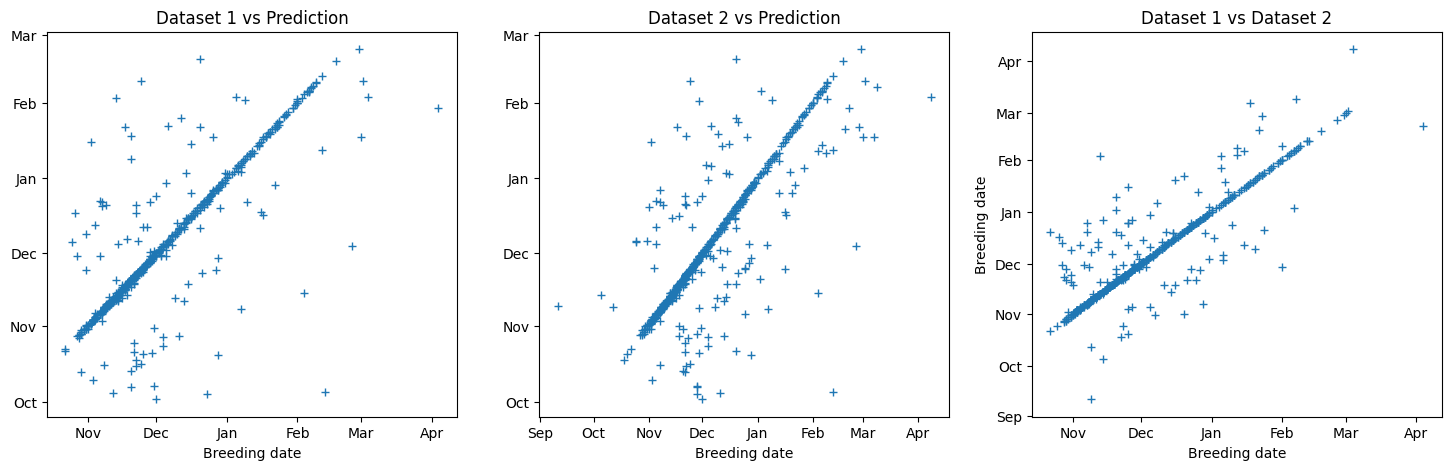

In [14]:
### Plot of regression

plot_regression_data = copy.copy(comparison_date)

plot_regression_data['dataset1_breeding_date'] = [i.replace(year = 2000) if i.month > 8 else i.replace(year = 2001) for i in plot_regression_data['dataset1_breeding_date']]
plot_regression_data['dataset2_breeding_date'] = [i.replace(year = 2000) if i.month > 8 else i.replace(year = 2001) for i in plot_regression_data['dataset2_breeding_date']]
plot_regression_data['start_date'] = [i.replace(year = 2000) if i.month > 8 else i.replace(year = 2001) for i in plot_regression_data['start_date']]

fig, axs = plt.subplots(1, 3, figsize = (18,5))
date_form = DateFormatter("%b")

plt.subplot(133)
plt.plot(plot_regression_data['dataset1_breeding_date'], plot_regression_data['dataset2_breeding_date'], '+')
plt.xlabel('Breeding date')
plt.ylabel('Breeding date')
axs[0].xaxis.set_major_formatter(date_form)
axs[0].yaxis.set_major_formatter(date_form)
plt.title('Dataset 1 vs Dataset 2')

plt.subplot(131)
plt.plot(plot_regression_data['dataset1_breeding_date'], plot_regression_data['start_date'], '+')
axs[1].xaxis.set_major_formatter(date_form)
axs[1].yaxis.set_major_formatter(date_form)
plt.xlabel('Breeding date')
plt.title('Dataset 1 vs Prediction')

plt.subplot(132)
plt.plot(plot_regression_data['dataset2_breeding_date'], plot_regression_data['start_date'], '+')
axs[2].xaxis.set_major_formatter(date_form)
axs[2].yaxis.set_major_formatter(date_form)
plt.xlabel('Breeding date')
plt.title('Dataset 2 vs Prediction')

# plt.savefig('breeding_dates_vs_breeding_dates.png', bbox_inches='tight')

In [15]:
### Representation
age_list = list({int(x) for x in data_proba["age"] if pd.notna(x)})
acc_age_spe_output = []
acc_age_spe_bdate = []
n_age_spe_output = []
n_age_spe_bdate = []
for i in age_list:
    df_age = (data_proba.loc[(data_proba["age"] == i)])
    n_age_spe_output.append(len(df_age))
    acc_age_spe_output.append(sum(df_age["dataset1_outcome"] == df_age["pred_outcome"]) / len(df_age))


results_bdate = copy.copy(comparison_date)
age_list_bdate = list({int(x) for x in results_bdate["age"] if pd.notna(x)})

for i in age_list_bdate:
    temp_df = (results_bdate.loc[results_bdate["age"] == i])
    n_age_spe_bdate.append(len(temp_df))
    acc_age_spe_bdate.append(sum(temp_df["val_date_pred_dataset1"]) / len(temp_df))
    
results_M = data_proba.loc[data_proba["pred_M_F"] == "M"]
age_list_M = list({int(x) for x in results_M["age"] if pd.notna(x)})
acc_age_spe_output_M = []
acc_age_spe_bdate_M = []
for i in age_list_M:
    temp_df = (results_M.loc[results_M["age"] == i])
    acc_age_spe_output_M.append(sum(temp_df["dataset1_outcome"] == temp_df["pred_outcome"]) / len(temp_df))
    
results_bdate_M = comparison_date.loc[comparison_date["pred_M_F"] != "M"]
age_list_bdate_M = list({int(x) for x in results_bdate_M["age"] if pd.notna(x)})
for i in age_list_bdate_M:
    temp_df = (results_bdate_M.loc[results_bdate_M["age"] == i])
    acc_age_spe_bdate_M.append(sum(temp_df["val_date_pred_dataset1"]) / len(temp_df))
    
results_F = data_proba.loc[data_proba["pred_M_F"] == "F"]
age_list_F = list({int(x) for x in results_F["age"] if pd.notna(x)})
acc_age_spe_output_F = []
acc_age_spe_bdate_F = []
for i in age_list_F:
    temp_df = (results_F.loc[results_F["age"] == i])
    acc_age_spe_output_F.append(sum(temp_df["dataset1_outcome"] == temp_df["pred_outcome"]) / len(temp_df))
    
results_bdate_F = comparison_date.loc[comparison_date["pred_M_F"] != "F"]
age_list_bdate_F = list({int(x) for x in results_bdate_F["age"] if pd.notna(x)})
for i in age_list_bdate_F:
    temp_df = (results_bdate_F.loc[results_bdate_F["age"] == i])
    acc_age_spe_bdate_F.append(sum(temp_df["val_date_pred_dataset1"]) / len(temp_df))


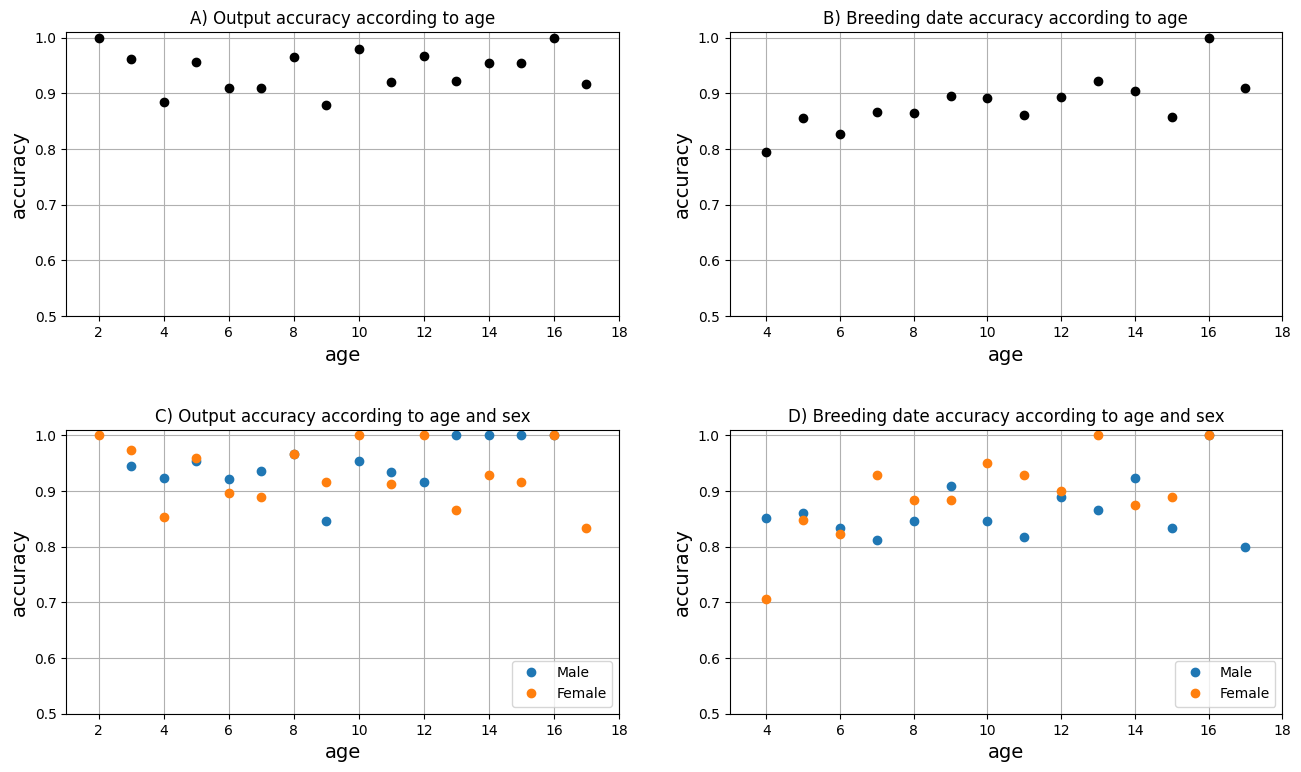

In [16]:
plt.figure()

plt.subplot(221)
plt.title('A) Output accuracy according to age')
plt.plot(age_list[1:-3],acc_age_spe_output[1:-3],'ko')
plt.axis([1, max(age_list)-3 , 0.5, 1.01])
plt.xticks([x*2 for x in range(1,10)])
plt.xlabel('age', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.grid(True)

plt.subplot(222)
plt.title('B) Breeding date accuracy according to age')
plt.plot(age_list_bdate[1:-3],acc_age_spe_bdate[1:-3],'ko')
plt.axis([3, max(age_list_bdate)-3 , 0.5, 1.01])
plt.xticks([x*2 for x in range(2,10)])
plt.xlabel('age', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.grid(True)

plt.subplot(223)
plt.title('C) Output accuracy according to age and sex')
plt.plot(age_list_M[1:-3],acc_age_spe_output_M[1:-3],'o',label='Male')
plt.legend()
plt.plot(age_list_F[1:-3],acc_age_spe_output_F[1:-3],'o',label='Female')
plt.legend(loc='lower right')
plt.axis([1, max(age_list)-3 , 0.5, 1.01])
plt.xticks([x*2 for x in range(1,10)])
plt.xlabel('age', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.grid(True)

plt.subplot(224)
plt.title('D) Breeding date accuracy according to age and sex')
plt.plot(age_list_bdate_M[1:-3],acc_age_spe_bdate_M[1:-3],'o',label='Male')
plt.legend()
plt.plot(age_list_bdate_F[1:-3],acc_age_spe_bdate_F[1:-3],'o',label='Female')
plt.legend(loc='lower right')
plt.axis([3, max(age_list)-3 , 0.5, 1.01])
plt.xticks([x*2 for x in range(2,10)])
plt.xlabel('age', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.grid(True)

plt.subplots_adjust(top=1.5, bottom=0.08, left=0.10, right=2, hspace=0.4,
                    wspace=0.2)
# plt.savefig('accuracy_graphs.png', bbox_inches='tight')

In [17]:
pw_fit = piecewise_regression.Fit(age_list_bdate[1:-3],acc_age_spe_bdate[1:-3], n_breakpoints=1)
pw_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                       14
No. Model Parameters                    4
Degrees of Freedom                     10
Res. Sum of Squares             0.0128803
Total Sum of Squares              0.02999
R Squared                        0.570511
Adjusted R Squared               0.379628
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               0.733965       0.0901       8.1501         1e-05      0.53331      0.93462
alpha1             0.0185959        0.016       1.1589         0.273    -0.017156     0.054348
beta1             -0.0118512       0.0165     -0.71718             -     -0.04867     0.024968
breakpoint1          6.90073         3.21            -             -     -0.24589       14.047
-----------------

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       14\nNo. Model Parameters                    4\nDegrees of Freedom                     10\nRes. Sum of Squares             0.0128803\nTotal Sum of Squares              0.02999\nR Squared                        0.570511\nAdjusted R Squared               0.379628\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst               0.733965       0.0901       8.1501         1e-05      0.53

In [18]:
### Age-specific and Sex-specific accuracies according to dataset 1:
print("Age-specific and Sex-specific accuracy of outcome classification and breeding date according to dataset 1:")
results_F = data_proba.loc[data_proba["pred_M_F"] == "F"]
acc_age_spe_output_F = []
print('Outcome accuracy for females: ' + str(sum(results_F["dataset1_outcome"] == results_F["pred_outcome"]) / len(results_F)))

results_bdate_F = comparison_date.loc[comparison_date["pred_M_F"] != "F"]
print('Breeding date accuracy for females: ' + str(sum(results_bdate_F["val_date_pred_dataset1"]) / len(results_bdate_F)))

results_M = data_proba.loc[data_proba["pred_M_F"] == "M"]
acc_age_spe_output_M = []
print('Outcome accuracy for males: ' + str(sum(results_M["dataset1_outcome"] == results_M["pred_outcome"]) / len(results_M)))

results_bdate_M = comparison_date.loc[comparison_date["pred_M_F"] != "M"]
print('Breeding date accuracy for males: ' + str(sum(results_bdate_M["val_date_pred_dataset1"]) / len(results_bdate_M)))

Age-specific and Sex-specific accuracy of outcome classification and breeding date according to dataset 1:
Outcome accuracy for females: 0.9320175438596491
Breeding date accuracy for females: 0.8888888888888888
Outcome accuracy for males: 0.9448818897637795
Breeding date accuracy for males: 0.8526011560693642


AUC scores for B vs. NB: 
Pred. vs. Dat.1 AUC: 0.9927746122190566
Best Threshold=0.559012, AUC=0.993

Pred. vs. Dat.2 AUC: 0.9759376664433105
Best Threshold=0.809900, G-Mean=0.945


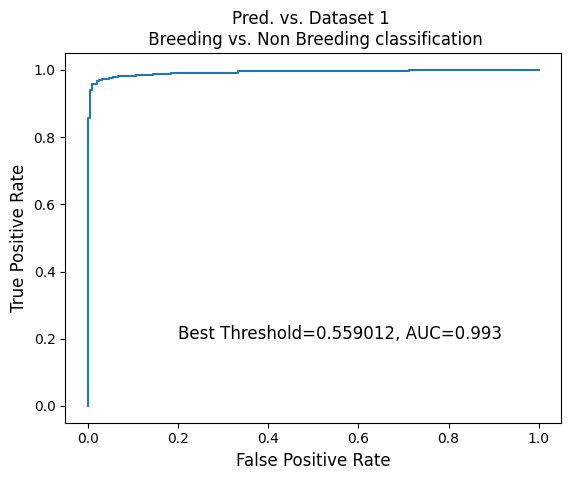

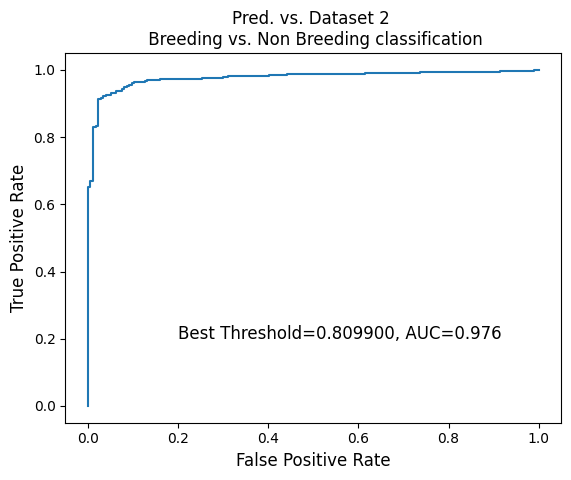

In [19]:
### AUC-ROC Curves for B vs. NB:

print("AUC scores for B vs. NB: ")
data_proba_NB = copy.copy(data_proba)
data_proba_NB['dataset1_outcome'] = data_proba_NB['dataset1_outcome'].replace('NB', 0)
data_proba_NB['dataset1_outcome'] = data_proba_NB['dataset1_outcome'].replace('F', 1)
data_proba_NB['dataset1_outcome'] = data_proba_NB['dataset1_outcome'].replace('S', 1)

data_proba_NB['dataset2_outcome'] = data_proba_NB['dataset2_outcome'].replace('NB', 0)
data_proba_NB['dataset2_outcome'] = data_proba_NB['dataset2_outcome'].replace('F', 1)
data_proba_NB['dataset2_outcome'] = data_proba_NB['dataset2_outcome'].replace('S', 1)

### Pred. vs. Dataset 1
fpr, tpr, thresholds = metrics.roc_curve(data_proba_NB['dataset1_outcome'], data_proba_NB['proba_B'])

auc = metrics.roc_auc_score(data_proba_NB['dataset1_outcome'], data_proba_NB['proba_B'])
print('Pred. vs. Dat.1 AUC: ' + str(auc))
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, AUC=%.3f' % (thresholds[ix], auc))

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.title('Pred. vs. Dataset 1 \n Breeding vs. Non Breeding classification')
plt.text(0.2, 0.2, 'Best Threshold=%f, AUC=%.3f' % (thresholds[ix], auc), fontsize = 12)
# plt.savefig('AUC_dataset1_breeding.pdf', bbox_inches='tight')

### Pred. vs. Dataset 2
fpr, tpr, thresholds = metrics.roc_curve(data_proba_NB['dataset2_outcome'], data_proba_NB['proba_B'])

auc = metrics.roc_auc_score(data_proba_NB['dataset2_outcome'], data_proba_NB['proba_B'])
print('\nPred. vs. Dat.2 AUC: ' + str(auc))
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#create ROC curve
plt.figure()
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.title('Pred. vs. Dataset 2 \n Breeding vs. Non Breeding classification')
plt.text(0.2, 0.2, 'Best Threshold=%f, AUC=%.3f' % (thresholds[ix], auc), fontsize = 12)
# plt.savefig('AUC_dataset2_breeding.pdf', bbox_inches='tight')
plt.show()

AUC scores for F vs. S: 
Pred. vs. Dat.1 AUC: 0.991897233201581
Best Threshold=0.966146, G-Mean=0.972

Pred. vs. Dat.2 AUC: 0.9935198777373363
Best Threshold=0.981121, G-Mean=0.985


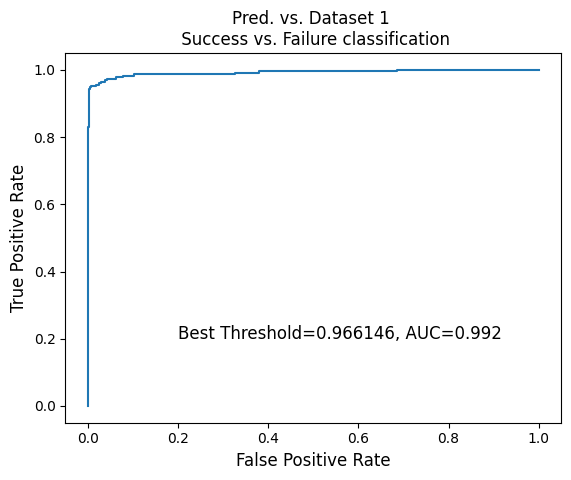

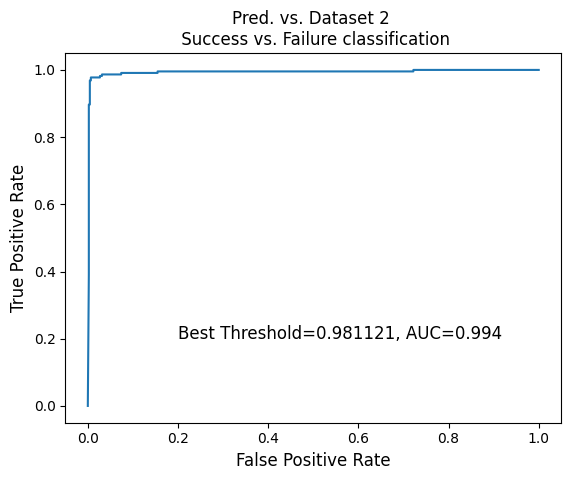

In [20]:
### AUC-ROC Curves for F vs. S:

print("AUC scores for F vs. S: ")
### Pred. vs. Dataset 1
data_proba_SF = copy.copy(data_proba.loc[data_proba["dataset1_outcome"] != "NB"])

data_proba_SF['dataset1_outcome'] = data_proba_SF['dataset1_outcome'].replace('F', 0)
data_proba_SF['dataset1_outcome'] = data_proba_SF['dataset1_outcome'].replace('S', 1)

fpr, tpr, thresholds = metrics.roc_curve(data_proba_SF['dataset1_outcome'], data_proba_SF['proba_S'])

auc = metrics.roc_auc_score(data_proba_SF['dataset1_outcome'], data_proba_SF['proba_S'])
print('Pred. vs. Dat.1 AUC: ' + str(auc))
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.title('Pred. vs. Dataset 1 \n Success vs. Failure classification')
plt.text(0.2, 0.2, 'Best Threshold=%f, AUC=%.3f' % (thresholds[ix], auc), fontsize = 12)
# plt.savefig('AUC_dataset1_success.pdf', bbox_inches='tight')


### Pred. vs. Dataset 2

data_proba_SF = copy.copy(data_proba.loc[data_proba["dataset2_outcome"] != "NB"])

data_proba_SF['dataset2_outcome'] = data_proba_SF['dataset2_outcome'].replace('F', 0)
data_proba_SF['dataset2_outcome'] = data_proba_SF['dataset2_outcome'].replace('S', 1)

fpr, tpr, thresholds = metrics.roc_curve(data_proba_SF['dataset2_outcome'], data_proba_SF['proba_S'])

auc = metrics.roc_auc_score(data_proba_SF['dataset2_outcome'], data_proba_SF['proba_S'])
print('\nPred. vs. Dat.2 AUC: ' + str(auc))
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

#create ROC curve
plt.figure()
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.title('Pred. vs. Dataset 2 \n Success vs. Failure classification')
plt.text(0.2, 0.2, 'Best Threshold=%f, AUC=%.3f' % (thresholds[ix], auc), fontsize = 12)
# plt.savefig('AUC_dataset2_success.pdf', bbox_inches='tight')
plt.show()

Average score for correctly classified breeding: 0.99149984
Average score for misclassified breeding: 0.7806425


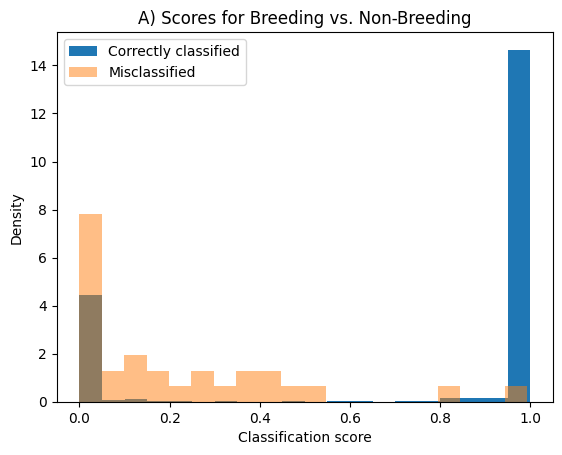

In [40]:
plt.hist(data_proba.loc[data_proba["pred_NB_B"] == data_proba["dataset1_outcome_NB_B"], 'proba_B'], density=True, bins=20, label= 'Correctly classified')
plt.hist(data_proba.loc[data_proba["pred_NB_B"] != data_proba["dataset1_outcome_NB_B"], 'proba_B'], bins=20, density=True, alpha=0.5, label= 'Misclassified')
plt.ylabel('Density')
plt.xlabel('Classification score')
plt.title('A) Scores for Breeding vs. Non-Breeding')
plt.legend()
plt.savefig('distribution_scores_breedingstatus.pdf', bbox_inches='tight')

print("Average score for correctly classified breeding: " + 
      str(np.mean(data_proba.loc[(data_proba["pred_NB_B"] == data_proba["dataset1_outcome_NB_B"]) & (data_proba["pred_NB_B"] == 'B'), 'proba_B'])))
print("Average score for misclassified breeding: " + 
      str(np.mean(data_proba.loc[(data_proba["pred_NB_B"] != data_proba["dataset1_outcome_NB_B"]) & (data_proba["pred_NB_B"] == 'B'), 'proba_B'])))

Average score for correctly classified success: 0.9953024
Average score for misclassified success: 0.78537655


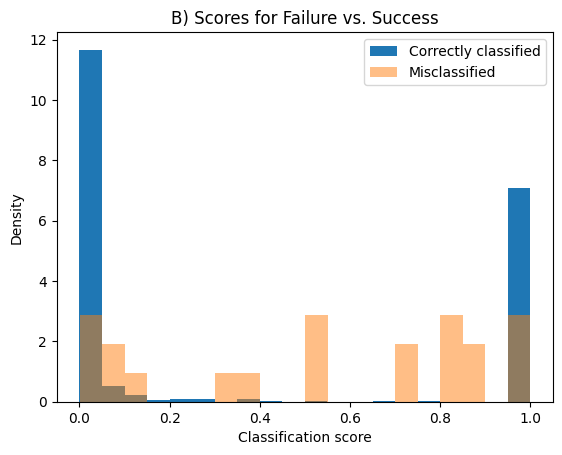

In [41]:
plt.hist(data_comparison_SF.loc[data_comparison_SF["pred_S_F"] == data_comparison_SF["dataset1_outcome"], 'proba_S'], density=True, bins=20, label= 'Correctly classified')
plt.hist(data_comparison_SF.loc[data_comparison_SF["pred_S_F"] != data_comparison_SF["dataset1_outcome"], 'proba_S'], bins=20, density=True, alpha=0.5, label= 'Misclassified')
plt.ylabel('Density')
plt.xlabel('Classification score')
plt.title('B) Scores for Failure vs. Success')
plt.legend()
plt.savefig('distribution_scores_breedingoutcome.pdf', bbox_inches='tight')

print("Average score for correctly classified success: " + 
      str(np.mean(data_comparison_SF.loc[(data_comparison_SF["pred_S_F"] == data_comparison_SF["dataset1_outcome"]) & (data_comparison_SF["pred_S_F"] == 'S'), 'proba_S'])))
print("Average score for misclassified success: " + 
      str(np.mean(data_comparison_SF.loc[(data_comparison_SF["pred_S_F"] != data_comparison_SF["dataset1_outcome"]) & (data_comparison_SF["pred_S_F"] == 'S'), 'proba_S'])))